In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

Extent       Date
0    1040455.516 1979-01-01
1     239334.118 1979-02-01
2     557365.154 1979-03-01
3    2054855.924 1979-04-01
4    2973925.625 1979-05-01
..           ...        ...
533  3137598.938 2023-06-01
534  3201783.453 2023-07-01
535  2973294.266 2023-08-01
536  3354839.711 2023-09-01
537  3325613.245 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 38s 506ms/step - loss: 0.3305 - root_mean_squared_error: 0.5749 - val_loss: 0.1626 - val_root_mean_squared_error: 0.4032
Epoch 2/50
53/53 [==============================] - 25s 480ms/step - loss: 0.0880 - root_mean_squared_error: 0.2967 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2576
Epoch 3/50
53/53 [==============================] - 25s 472ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2287
Epoch 4/50
53/53 [==============================] - 25s 487ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1988
Epoch 5/50
53/53 [==============================] - 27s 510ms/step - loss: 0.0267 - root_mean_squared_error: 0.1635 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1677
Epoch 6/50
53/53 [==============================] - 27s 522ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.0214 

Epoch 30/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 31/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1022
Epoch 32/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0079 - root_mean_squared_error: 0.0892 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 33/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 34/50
53/53 [==============================] - 4s 79ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 35/50
53/53 [==============================] - 27s 520ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0074 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

12.98853816986084 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

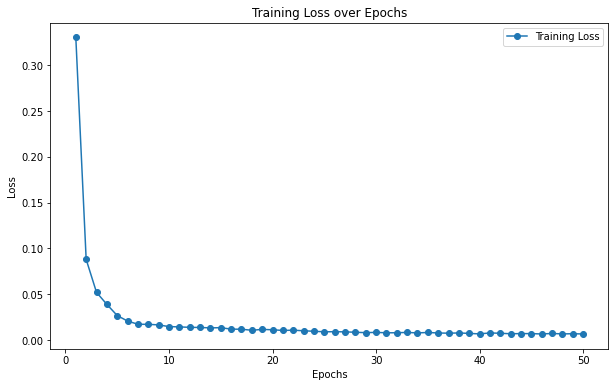

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

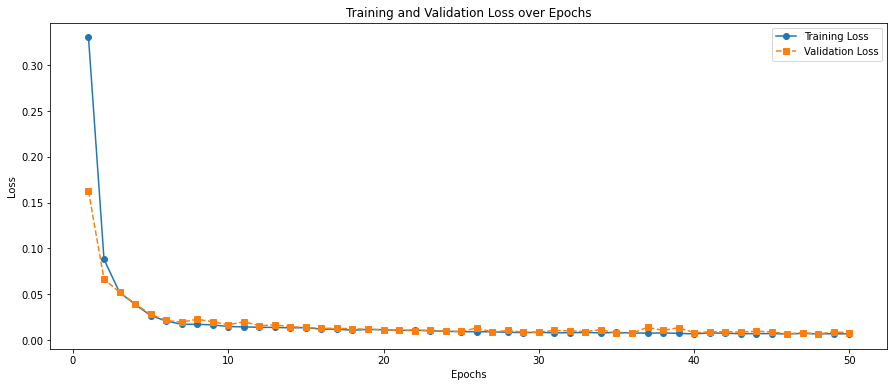

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 41ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07872836788119739
MAE : 0.05828794474537127


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        3.691540e+06    3656196.531
1        3.890516e+06    3794128.369
2        3.919260e+06    3885746.442
3        3.822868e+06    3909211.179
4        3.470004e+06    3499167.351
5        2.584317e+06    2715890.297
6        1.038290e+06    1053272.694
7        5.157159e+05     368862.123
8        8.152326e+05     979418.298
9        1.657476e+06    2086269.569
10       2.559848e+06    2852731.016
11       3.175706e+06    3452823.613
12       3.555870e+06    3846843.974
13       3.762263e+06    4005222.451
14       3.849198e+06    4129684.505
15       3.786261e+06    4130311.577
16       3.463818e+06    3987590.376
17       2.535262e+06    2531664.630
18       9.792427e+05     864796.598
19       5.528095e+05     366098.623
20       9.074756e+05    1324063.884
21       1.805238e+06    2094086.684
22       2.746024e+06    2706708.526
23       3.348623e+06    3380172.167
24       3.717538e+06    3975727.475
25       3.932432e+06    4016497.161
26       4.032114e+06    4134594.766
27       3.988925e+06    4278165.933
28       3.660942e+06    3893945.909
29       2.729705e+06    2389171.083
30       1.016387e+06     896425.932
31       5.208964e+05     251374.224
32       9.326392e+05     455056.048
33       1.849019e+06    1780625.872
34       2.791663e+06    2914989.101
35       3.349806e+06    3561620.245
36       3.713883e+06    3991717.506
37       3.943580e+06    4559070.778
38       4.042024e+06    4596327.081
39       3.965596e+06    4565650.139
40       3.606220e+06    4061902.846
41       2.443928e+06    2336900.967
42       6.274858e+05     696917.659
43       2.761797e+05     213657.789
44       7.244212e+05     765773.883
45       1.664786e+06    1951730.202
46       2.697462e+06    2610971.814
47       3.448293e+06    3137598.938
48       3.911452e+06    3201783.453
49       4.151994e+06    2973294.266
50       4.248913e+06    3354839.711
51       4.210824e+06    3325613.245

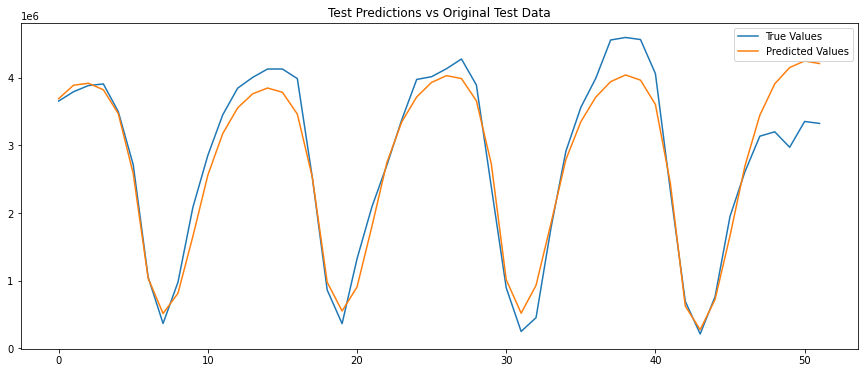

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 48ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

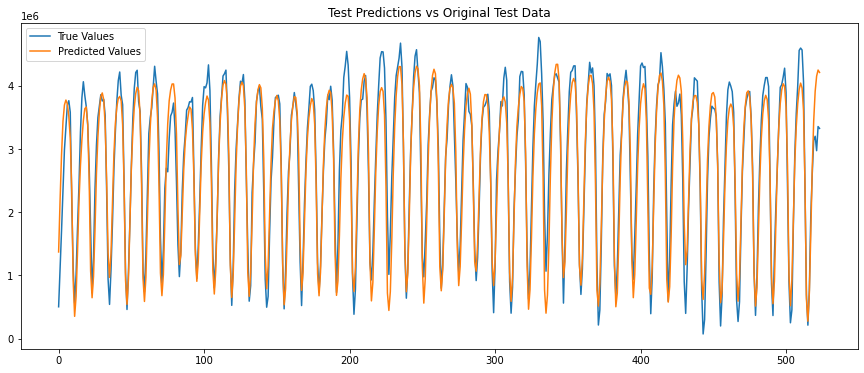

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()